In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import pandas as pd

ROOT_PATH = "/Mounts/rbg-storage1/users/yujieq/bms/"
gold = pd.read_csv(ROOT_PATH + 'data/molbank/pubchem/valid.csv')

(491, 788, 3)
(384, 384, 3)
[255 255 255]


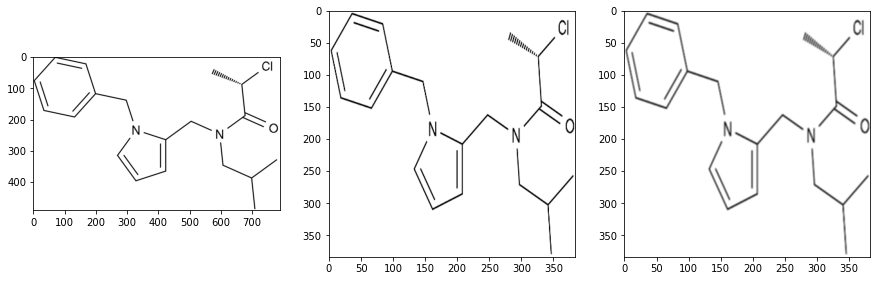

(325, 1100, 3)
(384, 384, 3)
[253 255 255]


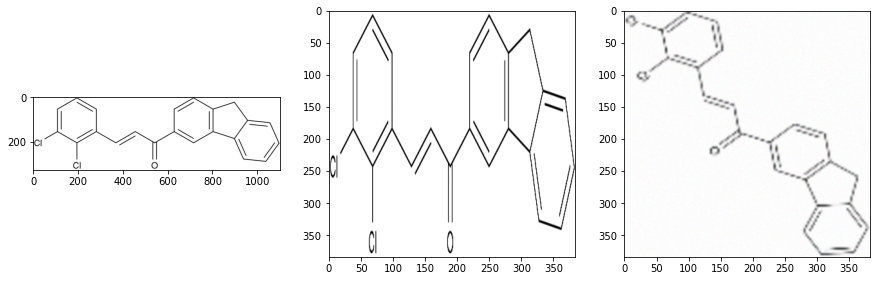

(344, 580, 3)
(384, 384, 3)
[251 255 255]


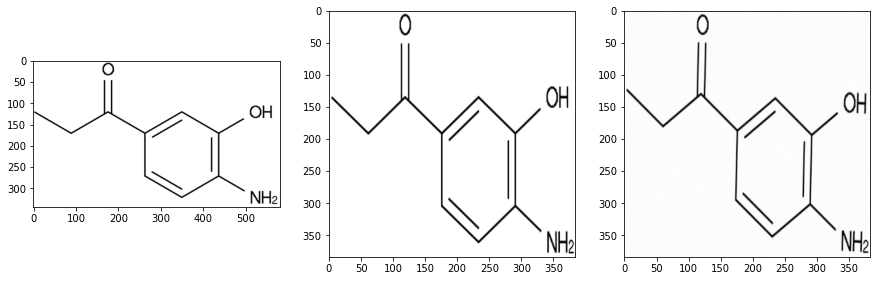

(325, 1046, 3)
(384, 384, 3)
[255 255 255]


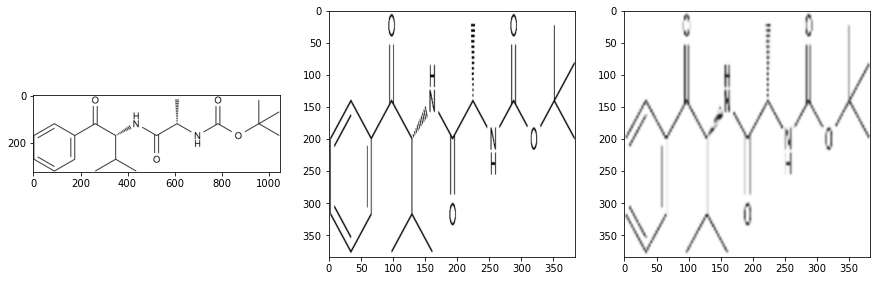

(375, 1431, 3)
(384, 384, 3)
[255 255 255]


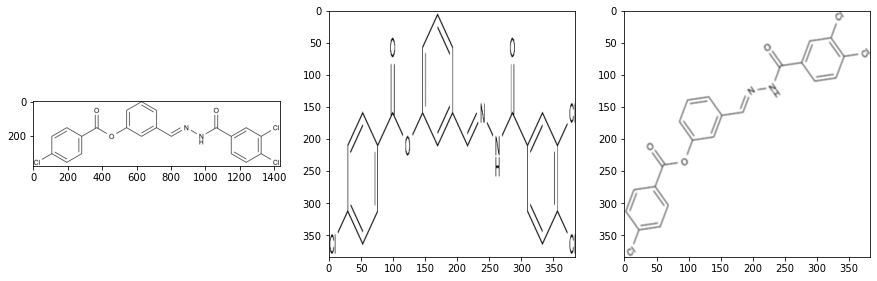

(329, 1068, 3)
(384, 384, 3)
[255 255 255]


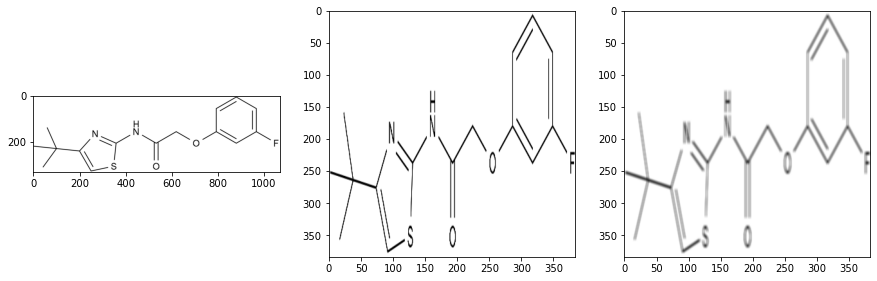

(338, 788, 3)
(384, 384, 3)
[255 255 255]


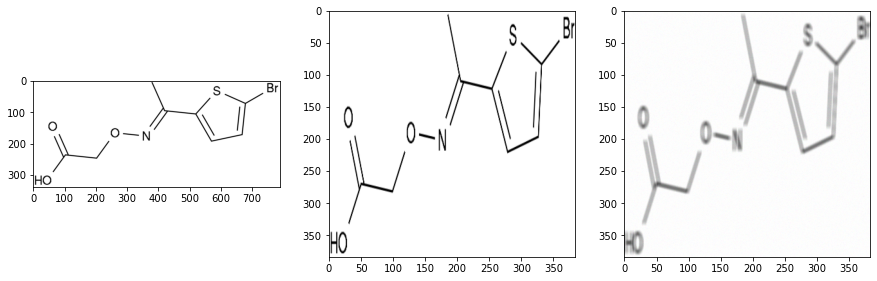

(530, 969, 3)
(384, 384, 3)
[248 237 255]


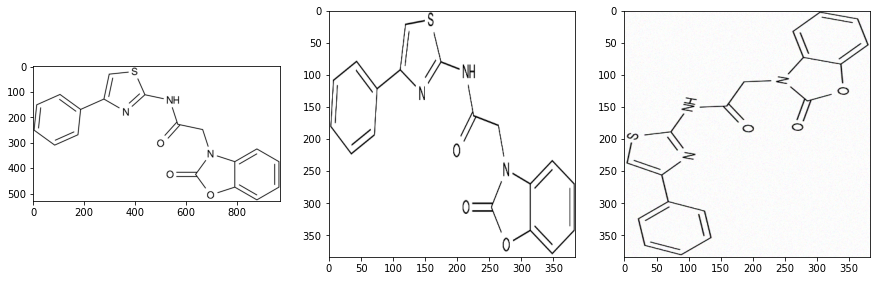

(319, 960, 3)
(384, 384, 3)
[255 255 253]


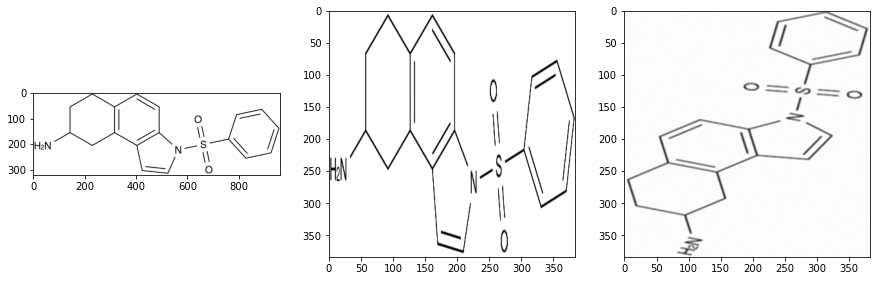

(649, 948, 3)
(384, 384, 3)
[255 255 255]


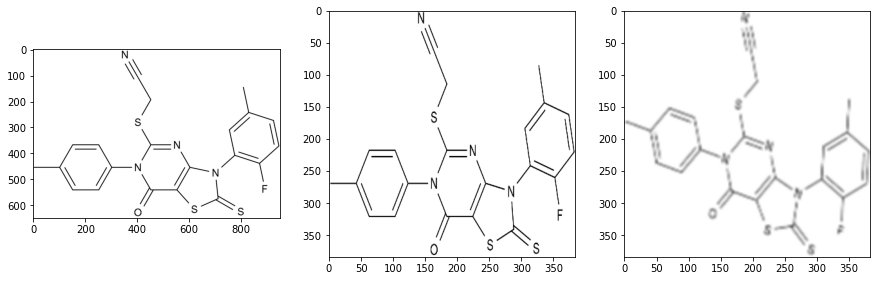

In [45]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from bms.augment import ExpandSafeRotate, CropWhite, ResizePad

    
def visualize(image, org_image, aug_image):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(org_image)
    plt.subplot(1,3,3)
    plt.imshow(aug_image)
    plt.show()


Atrans = A.Compose([
        ExpandSafeRotate(limit=90, border_mode=cv2.BORDER_CONSTANT, value=(255,255,255)),
        CropWhite(pad=5),
        A.Resize(384, 384),
        A.Downscale(scale_min=0.25, scale_max=0.5, interpolation=1),
        A.Blur(),
        A.GaussNoise(),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
#         ToTensorV2(),
    ])

Otrans = A.Compose([
        CropWhite(pad=5),
#         ResizePad(384, 384, interpolation=cv2.INTER_NEAREST),
        A.Resize(384, 384),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
    ])

for i, row in gold[:10].iterrows():
    file_path = '../'+row['file_path']
    image = cv2.imread(file_path)
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #.astype(np.float32)
    org_image = Otrans(image=image)['image']
    aug_image = Atrans(image=image)['image']
    print(aug_image.shape)
    print(aug_image[0][0])
    cv2.imwrite(f'tmp/{i}.png', aug_image)
    visualize(image, org_image, aug_image)

In [37]:
img = cv2.imread('tmp/8.png')
print(img.shape)
h,w,_ = img.shape
for i in range(h):
    for j in range(w):
        if img[i,j].sum() < 100 *3:
            print(img[i,j])

(384, 384, 3)
[99 99 99]
[99 99 99]
[99 99 99]
[91 91 91]
[85 85 85]
[86 86 86]
[80 80 80]
[95 95 95]
[93 93 93]
[88 88 88]
[99 99 99]
[98 98 98]
[99 99 99]


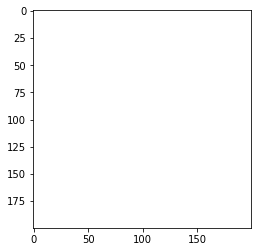

In [106]:
s= 'COc1ccccc1-n1[nH]c(C(=N)O)c2c1C(=O)N(c1ccc(N3CCC3=O)c(C)c1)CC2'
mol = Chem.MolFromSmiles(s)
# mol = Chem.MolFromInchi('InChI=1S/H2O/h1H2')
mol = Chem.MolFromSmiles('C')
print(mol)
img = Draw.MolsToGridImage([mol], subImgSize=(200, 200), molsPerRow=1)
plt.imshow(img)
img = np.array(img)
img = Atrans(image=img)['image']

In [182]:
from tqdm import tqdm

sizes = []

for image_id in tqdm(gold['image_id'].values[:10000]):
    file_path = get_train_file_path(image_id)
    image = cv2.imread(file_path)
    assert(image[:,:,0] == image[:,:,1]).all()
    assert(image[:,:,0] == image[:,:,2]).all()
    h, w, c = image.shape
    sizes.append([h, w])


  0%|          | 0/242419 [00:06<?, ?it/s]30.47it/s]

100%|██████████| 10000/10000 [01:49<00:00, 91.27it/s][A


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cc1c(C(O)=Nc2nccs2)c2ccccn2c1C(=O)c1ccc(F)cc1


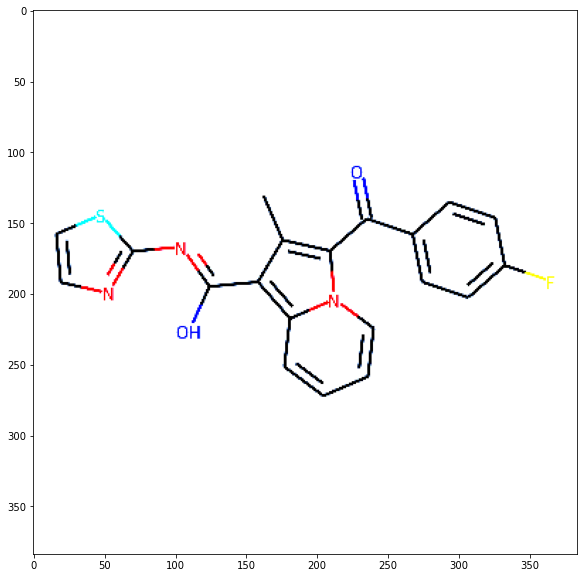

In [66]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import numpy as np

smiles = gold.loc[6, 'SMILES']
print(smiles)

mol = Chem.MolFromSmiles(smiles)
img = Draw.MolsToGridImage([mol], subImgSize=(384,384), molsPerRow=1)
img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img = Otrans(image=img)['image']
plt.figure(figsize=(10,10))
plt.imshow(img)

In [47]:
mol1 = Chem.MolFromSmiles("CSCC")
mol2 = Chem.MolFromSmiles("CCSC")
print(Chem.MolToInchi(mol1))
print(Chem.MolToInchi(mol2))

InChI=1S/C3H8S/c1-3-4-2/h3H2,1-2H3
InChI=1S/C3H8S/c1-3-4-2/h3H2,1-2H3
